In [1]:
# 导入单细胞分析的基本库
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置绘图默认风格
sc.set_figure_params(dpi=100, facecolor='white')

# 让日志输出更简洁
sc.settings.verbosity = 3

In [2]:
# 加载 .h5ad 文件（根据你的文件名改）
adata = sc.read_h5ad("2023nature_breast_EPT.h5ad")

# 查看数据基本信息
adata

AnnData object with n_obs × n_vars = 240804 × 33145
    obs: 'mapped_reference_assembly', 'mapped_reference_annotation', 'alignment_software', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'suspension_depleted_cell_types', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_percent_cell_viability', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'disease_ontology_term_id', 'sex_ontology_term_id', 'n_count_rna', 'n_feature_rna', 'percent_mito', 'percent_rb', 'sample_id', 'tissue_location', 'bmi_group', 'procedur

⚡ 数据集中没有以 'MT-' 开头的线粒体基因


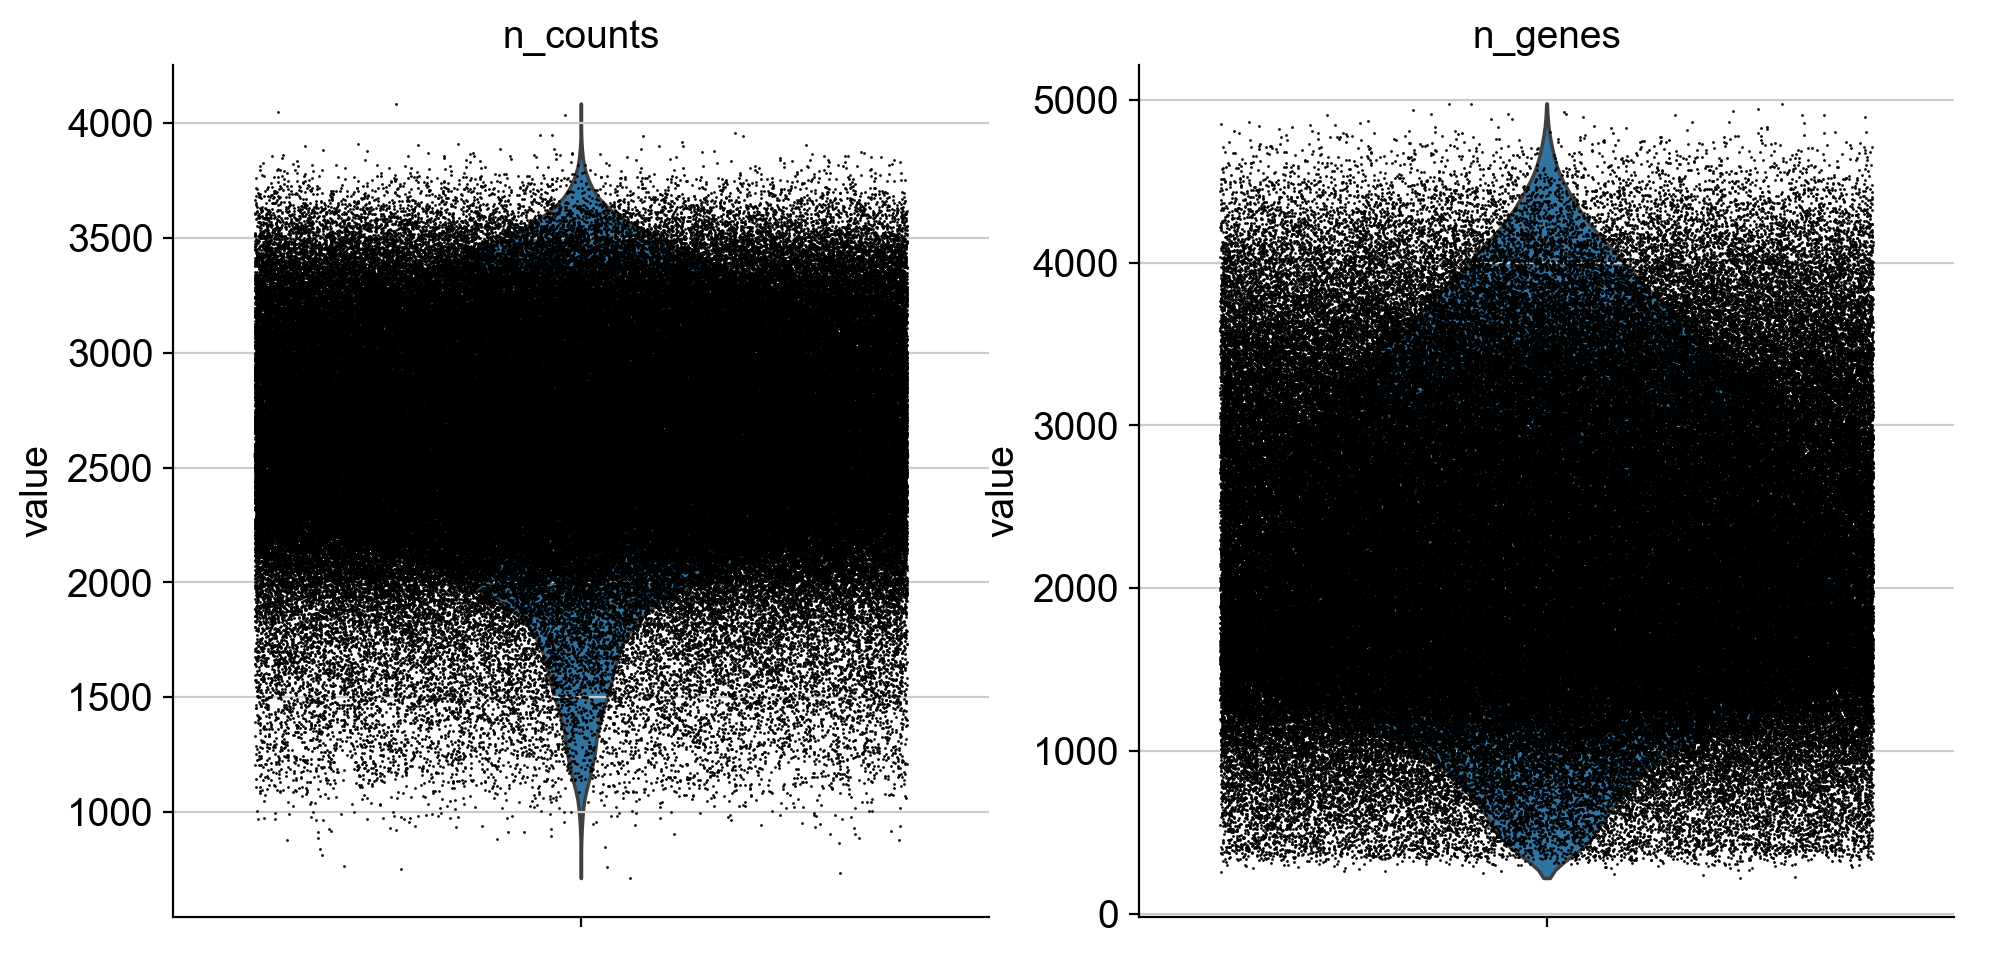

In [3]:
# 计算每个细胞的总计数和基因数
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1

# 如果有线粒体基因（名字以"MT-"开头），可以计算线粒体比例
mt_genes = adata.var_names.str.startswith('MT-')
if mt_genes.sum() > 0:
    adata.obs['percent_mito'] = np.sum(adata.X[:, mt_genes], axis=1).A1 / adata.obs['n_counts'] * 100
else:
    print("⚡ 数据集中没有以 'MT-' 开头的线粒体基因")

# 展示每个指标的分布情况
sc.pl.violin(adata, ['n_counts', 'n_genes'], jitter=0.4, multi_panel=True)

In [4]:
# 过滤细胞：保留总基因数>500、总转录本数>1000的细胞
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=1000)

print(adata.shape)  # 看看过滤后剩下多少细胞

filtered out 2190 cells that have less than 500 genes expressed
(238614, 33145)


In [5]:
# 归一化每个细胞的总表达量到 1万 (10,000)
sc.pp.normalize_total(adata, target_sum=1e4)

# 再做log1p变换（log(x+1)，更接近正态分布）
sc.pp.log1p(adata)

# 查看处理后的数据
adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 238614 × 33145
    obs: 'mapped_reference_assembly', 'mapped_reference_annotation', 'alignment_software', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'suspension_depleted_cell_types', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_percent_cell_viability', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'disease_ontology_term_id', 'sex_ontology_term_id', 'n_count_rna', 'n_feature_rna', 'percent_mito', 'percent_rb', 'sample_id', 'tissue_location', 'bmi_group', 'procedur

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
筛选出 2925 个高变基因


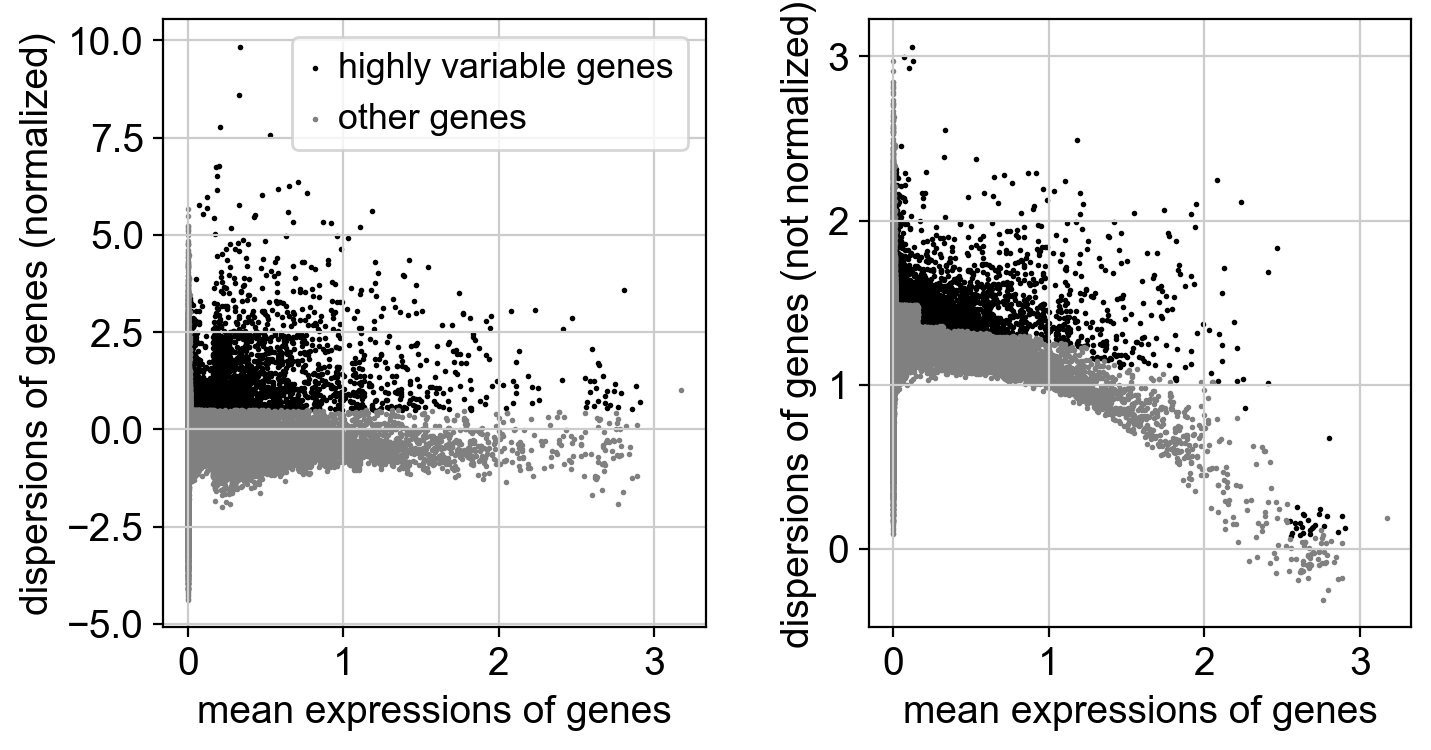

In [6]:
# 选择高变基因
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 查看筛选出多少高变基因
print(f"筛选出 {adata.var['highly_variable'].sum()} 个高变基因")

# 画出高变基因的分布图
sc.pl.highly_variable_genes(adata)

Index(['mapped_reference_assembly', 'mapped_reference_annotation',
       'alignment_software', 'donor_id',
       'self_reported_ethnicity_ontology_term_id',
       'donor_living_at_sample_collection', 'donor_menopausal_status',
       'organism_ontology_term_id', 'sample_uuid',
       'sample_preservation_method', 'tissue_ontology_term_id',
       'development_stage_ontology_term_id', 'sample_derivation_process',
       'sample_source', 'donor_BMI_at_collection',
       'suspension_depleted_cell_types', 'suspension_derivation_process',
       'suspension_dissociation_reagent', 'suspension_dissociation_time',
       'suspension_percent_cell_viability', 'suspension_uuid',
       'suspension_type', 'library_uuid', 'assay_ontology_term_id',
       'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id',
       'author_cell_type', 'cell_state', 'disease_ontology_term_id',
       'sex_ontology_term_id', 'n_count_rna', 'n_feature_rna', 'percent_mito',
       'percent_rb', 'sa

<Axes: ylabel='cell_type'>

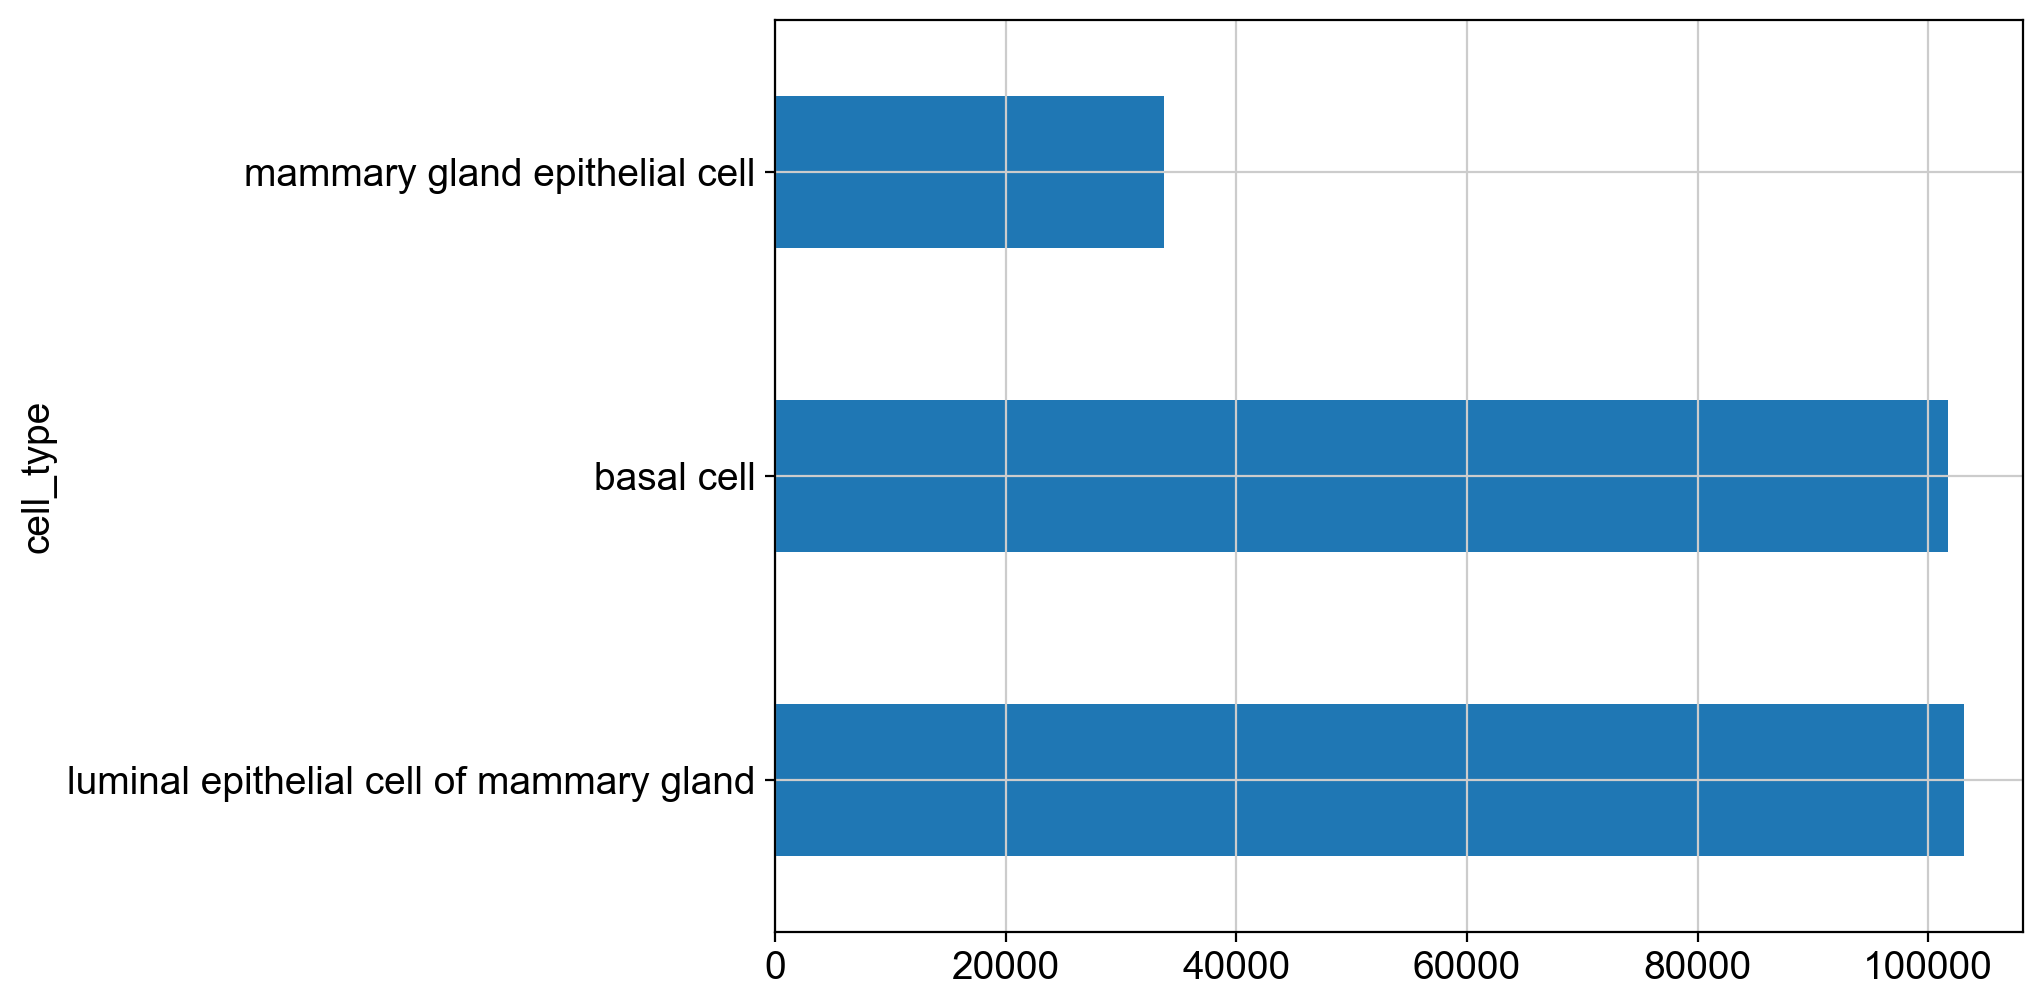

In [7]:
# 先列出adata.obs有哪些列（确认有哪些分组可以选）
print(adata.obs.columns)

# 假设你想查看 'cell_type' 这个分组变量
# 查看每个cell_type下有多少个细胞
print(adata.obs['cell_type'].value_counts())

# 如果你想更直观一点看，可以画个柱状图
adata.obs['cell_type'].value_counts().plot.barh(figsize=(8,6))

In [8]:
# 先列出所有 cell_type 可能的注释
print(adata.obs['cell_type'].unique())

# 如果想更严谨一点，把 author_cell_type 也列一下
print(adata.obs['author_cell_type'].unique())

# 同时列一下 cell_state 字段（如果有）
print(adata.obs['cell_state'].unique())

['luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'basal cell']
Categories (3, object): ['basal cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell']
['LummHR-SCGB', 'LummHR-major', 'LummHR-active', 'Lumsec-basal', 'Lumsec-HLA', ..., 'Lumsec-myo', 'Lumsec-KIT', 'Lumsec-prol', 'Lumsec-lac', 'basal']
Length: 11
Categories (11, object): ['LummHR-SCGB', 'LummHR-active', 'LummHR-major', 'Lumsec-HLA', ..., 'Lumsec-major', 'Lumsec-myo', 'Lumsec-prol', 'basal']
['na', 'proliferating']
Categories (2, object): ['na', 'proliferating']


In [9]:
# 1. 筛选 Lumsec-KIT 群体
adata_lumsec_kit = adata[adata.obs['author_cell_type'] == 'Lumsec-KIT'].copy()

In [10]:
print(adata_lumsec_kit.shape)

(3188, 33145)


In [11]:
# 2. 确认 Lumsec-KIT 群体中 age_group 分布
print(adata_lumsec_kit.obs['age_group'].value_counts())

age_group
young    2842
old       346
Name: count, dtype: int64


In [12]:
import numpy as np

# 获取 young 和 old 的 index
young_idx = adata_lumsec_kit.obs[adata_lumsec_kit.obs['age_group'] == 'young'].index
old_idx = adata_lumsec_kit.obs[adata_lumsec_kit.obs['age_group'] == 'old'].index

# 随机抽取 346 个 young 细胞
np.random.seed(42)  # 设置随机种子，确保可重复
young_sampled = np.random.choice(young_idx, size=len(old_idx), replace=False)

# 合并 index
balanced_idx = old_idx.tolist() + young_sampled.tolist()

# 构建新的平衡子集
adata_balanced = adata_lumsec_kit[balanced_idx].copy()

# 查看分布
print(adata_balanced.obs['age_group'].value_counts())

age_group
old      346
young    346
Name: count, dtype: int64


In [13]:
sc.tl.rank_genes_groups(
    adata_balanced,
    groupby='age_group',
    reference='young',  # 对比参考组
    method='wilcoxon'
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [14]:
# 对平衡后的数据进行 log1p 转换（差异分析前的标准步骤）
sc.pp.log1p(adata_balanced)

In [15]:
import numpy as np
print(np.min(adata.X), np.max(adata.X))

0.0 4.3759418


In [16]:
import matplotlib.pyplot as plt
plt.hist(adata.X[~np.isnan(adata.X)].flatten(), bins=100)
plt.xlabel("Expression value")
plt.ylabel("Frequency")
plt.title("Distribution of adata.X values")
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [17]:
adata_balanced.raw = adata_balanced

In [18]:
sc.tl.rank_genes_groups(
    adata_balanced,
    groupby='age_group',
    reference='young',
    method='wilcoxon'
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [19]:
import pandas as pd

# 获取差异表达结果
result = adata_balanced.uns['rank_genes_groups']

# 提取比较结果（old 相对 young）
degs = pd.DataFrame({
    'gene': result['names']['old'],
    'logfoldchanges': result['logfoldchanges']['old'],
    'pvals': result['pvals']['old'],
    'pvals_adj': result['pvals_adj']['old'],
    'scores': result['scores']['old']
})

# 添加 symbol 注释
degs['symbol'] = degs['gene'].map(adata_balanced.var['feature_name'])

# 构建文件名
filename = "DEGs_LumsecKIT_balanced_n346_random_old_vs_young.xlsx"

# 保存结果
degs.to_excel(filename, index=False)
print(f"✅ 差异表达基因表已导出为：{filename}")

✅ 差异表达基因表已导出为：DEGs_LumsecKIT_balanced_n346_random_old_vs_young.xlsx
